# Azerbaijan GP

Major changes made:

- Dataset shift: change historical data to Baku-specific. (bias against rookies, can't be helped)
-  Normalisation of features for better correlation analysis
- Change of target variable: Average lap speed is a bad target variable given our dataset is vast and covers tracks other than Baku. For each track the avg lap speed is going to be different. [consider keeping if data has a bent towards Baku]
- Consider classification using XGBClassifier, figure out hyperparams to prevent overfitting (hyperops)
- OR regression using XGBoost on Baku data.
- Add Qualifying Time
- Add average of race pace in qualifying sessions instead of best pace.
- Convert podium predictor to string.

FINAL APPROACH:
- Classification on podium position using XGBClassifier/ Random Forest / LightGBM with hyperopt. Use imputation and normalisation

In [10]:
%pip install -q --upgrade numpy scikit-learn fastf1 keras xgboost

Note: you may need to restart the kernel to use updated packages.


In [11]:
import fastf1
import pandas as pd
fastf1.Cache.enable_cache("cache")

In [12]:
def get_weather_data(year,race,session):
    cur_session=fastf1.get_session(year,race,session)
    cur_session.load()
    weather_df=cur_session.weather_data
    weather_data={}
    weather_data["AirTemp"]=weather_df["AirTemp"].mean() # Average Air Temp in degrees Celsius
    weather_data["Humidity"]=weather_df["Humidity"].mean() # Average Humidity in % 
    weather_data["Pressure"]=weather_df["Pressure"].mean() # Average Air pressure in mbar
    weather_data["Rain"]=weather_df["Rainfall"].any() # Check if there was any rainfall
    weather_data["WindSpeed"]=weather_df["WindSpeed"].mean() # Average Wind Speed in m/s
    weather_data["TrackTemp"]=weather_df["TrackTemp"].mean() # Average Track Temperature
    
    return weather_data

In [13]:
def get_clean_air_race_pace(year, race):
    all_personal_bests = []
    
    for session in ["FP1", "FP2", "FP3"]:
        try:
            cur_session = fastf1.get_session(year, race, session)
            cur_session.load()
            laps = cur_session.laps
            
            laps = laps.drop(columns=['Time', 'DriverNumber', 'LapNumber', 'Stint',
            'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
            'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
            'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST',
            'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
            'LapStartDate', 'Position', 'DeletedReason',
            'FastF1Generated', 'IsAccurate'])

            laps = laps[(laps['TrackStatus']=='1') & (laps['Deleted']==False) & (laps.LapTime.notnull())]
            laps = laps.drop(columns=['Deleted','TrackStatus'])

            # Find Personal Best for this session
            personalbest = laps[laps['IsPersonalBest']==True]
            if not personalbest.empty:
                personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
                personalbest = personalbest.drop(columns=['LapTime'])
                personalbest['Session'] = session  # Track which session
                all_personal_bests.append(personalbest)
                
        except Exception as e:
            print(f"Skipping {session} for {year} {race}: {e}")
            continue
    
    # Combine all sessions
    if all_personal_bests:
        combined_bests = pd.concat(all_personal_bests, ignore_index=True)
        
        # Find min lap time per driver across all sessions
        personalbest_map = combined_bests.loc[combined_bests.groupby('Driver')['LapTime (s)'].idxmin()]
        personalbest_map = personalbest_map.reset_index(drop=True)
        
        return personalbest_map
    else:
        return pd.DataFrame()  # Empty if no data found

In [14]:
# Build Model Train Data
# To be used for min-max normalization
from sklearn.preprocessing import MinMaxScaler
# To be used for Z-normalization (standardization)
from sklearn.preprocessing import StandardScaler
import logging

logging.getLogger('fastf1').setLevel(logging.ERROR)

train_sessions={2024:['Baku'],2025:['Australia','China','Japan','Bahrain','Saudi Arabia','Miami','Imola','Monaco','Spain','Canada','Austria','Silverstone','Belgium','Hungary','Netherlands','Monza']}
train_df=pd.DataFrame()
y=pd.DataFrame()

for year in train_sessions:
    for race in train_sessions[year]:
        cur_session=fastf1.get_session(year,race,'R')
        cur_session.load()
        print(f"--------------------------------------------------\nLoaded Data for {year} {race}\n--------------------------------------------------")
        cur_results=cur_session.results
        
        
        #-------DROP UNNECESSARY COLUMNS----------
        cur_results = cur_results.reset_index(drop=True)
        cur_results=cur_results.drop(columns=['DriverNumber', 'BroadcastName', 'DriverId', 'TeamName',
            'TeamColor', 'FirstName', 'LastName', 'FullName',
            'HeadshotUrl', 'CountryCode', 'Position', 'ClassifiedPosition',
            'Q1', 'Q2', 'Q3', 'Status', 'Points'])
        #-----------------------------------------
        
        cur_results.rename(columns={'Abbreviation':'Driver'},inplace=True)
        #--------CALCULATE TOTAL RACETIME---------
        # cur_results = cur_results.sort_values('Time',ascending=False).reset_index(drop=True)

        # Get winner's time in seconds
        cur_results.reset_index(drop=True,inplace=True)
        winner_time_seconds = cur_results.iloc[0]['Time'].total_seconds()

        cur_results['Time (s)'] = cur_results['Time'].dt.total_seconds()
        cur_results.loc[1:, 'Time (s)'] = winner_time_seconds + cur_results.loc[1:, 'Time (s)']

        #Winner
        cur_results.loc[0, 'Time (s)'] = winner_time_seconds

        cur_results['Time (s)'] = cur_results['Time (s)'].fillna(winner_time_seconds + 300)  # +5 minutes penalty
        
        #-----------------------------------------
        
        #----------CALCULATE TOTAL LAP TIME BY SECTOR AVERAGE---------
        cur_laps = cur_session.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()
        cur_laps.dropna(inplace=True)

        # convert lap and sector times to seconds
        for col in ["LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]:
            cur_laps[f"{col} (s)"] = cur_laps[col].dt.total_seconds()

        # aggregate sector times by driver
        sector_times = cur_laps.groupby("Driver").agg({
            "Sector1Time (s)": "mean",
            "Sector2Time (s)": "mean",
            "Sector3Time (s)": "mean"
        }).reset_index()

        sector_times["TotalSectorTime (s)"] = (
            sector_times["Sector1Time (s)"] +
            sector_times["Sector2Time (s)"] +
            sector_times["Sector3Time (s)"]
        )
        
        cur_results =  cur_results.merge(sector_times[["Driver", "TotalSectorTime (s)"]], on="Driver", how="left")
        
        y = pd.concat([y,cur_laps.groupby("Driver")["LapTime (s)"].mean().reindex(cur_results["Driver"])])
        #-------------------------------------------------------------
        
        #-------FEATURE ENGINEERING----------------
        cur_results['Grid_Gap_to_Pole'] = cur_results['GridPosition'] - cur_results['GridPosition'].min()

        cur_results['Quali_vs_Teammate'] = cur_results.groupby('TeamId')['GridPosition'].transform(lambda x: x - x.mean())

        cur_results['Race'] = race
        cur_results['Year'] = year
        #------------------------------------------
        
        #--------GET CLEAN AIR RACE PACE------------
        # Get clean air race pace (best clear track race pace among FP1, FP2 and FP3)
        clean_air_race_pace=get_clean_air_race_pace(year,race)
        
        clean_air_race_pace.drop(columns=['IsPersonalBest','Session'],inplace=True)
        pace_mapping=clean_air_race_pace.set_index('Driver')['LapTime (s)']
        
        cur_results['CleanAirPace_seconds'] = cur_results['Driver'].map(pace_mapping)
        #--------------------------------------------
        
        
        #-------MORE FEATURE ENGINEERING-----------
        cur_results['Practice_Gap_to_Fastest'] = cur_results['CleanAirPace_seconds'] - cur_results['CleanAirPace_seconds'].min()

        cur_results['Practice_vs_Quali_Rank'] = cur_results['CleanAirPace_seconds'].rank() - cur_results['GridPosition']

        cur_results['Quali_vs_Teammate'] = cur_results['Quali_vs_Teammate'].fillna(0)
        #-------------------------------------------

        #-------GET RACE DAY WEATHER DATA------------
        weather_data=get_weather_data(year,race,'R')
        cur_results = cur_results.assign(**weather_data)
        #--------------------------------------------
        
        #------------IS IT MONZA?-----------------
        if race!='Monza':
            cur_results['Is_Monza']=0
        else:
            cur_results['Is_Monza']=1
        
        train_df = pd.concat([train_df, cur_results], ignore_index=True)      
        
        
 

--------------------------------------------------
Loaded Data for 2024 Baku
--------------------------------------------------


/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A v

--------------------------------------------------
Loaded Data for 2025 Australia
--------------------------------------------------


/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A v

--------------------------------------------------
Loaded Data for 2025 China
--------------------------------------------------


/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()


Skipping FP2 for 2025 China: Session type 'FP2' does not exist for this event
Skipping FP3 for 2025 China: Session type 'FP3' does not exist for this event
--------------------------------------------------
Loaded Data for 2025 Japan
--------------------------------------------------


/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A v

--------------------------------------------------
Loaded Data for 2025 Bahrain
--------------------------------------------------


/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A v

--------------------------------------------------
Loaded Data for 2025 Saudi Arabia
--------------------------------------------------


/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A v

--------------------------------------------------
Loaded Data for 2025 Miami
--------------------------------------------------


/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()


Skipping FP2 for 2025 Miami: Session type 'FP2' does not exist for this event
Skipping FP3 for 2025 Miami: Session type 'FP3' does not exist for this event
--------------------------------------------------
Loaded Data for 2025 Imola
--------------------------------------------------


/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A v

--------------------------------------------------
Loaded Data for 2025 Monaco
--------------------------------------------------


/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A v

--------------------------------------------------
Loaded Data for 2025 Spain
--------------------------------------------------


/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A v

--------------------------------------------------
Loaded Data for 2025 Canada
--------------------------------------------------


/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A v

--------------------------------------------------
Loaded Data for 2025 Austria
--------------------------------------------------


/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A v

--------------------------------------------------
Loaded Data for 2025 Silverstone
--------------------------------------------------


/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A v

--------------------------------------------------
Loaded Data for 2025 Belgium
--------------------------------------------------


/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()


Skipping FP2 for 2025 Belgium: Session type 'FP2' does not exist for this event
Skipping FP3 for 2025 Belgium: Session type 'FP3' does not exist for this event
--------------------------------------------------
Loaded Data for 2025 Hungary
--------------------------------------------------


/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A v

--------------------------------------------------
Loaded Data for 2025 Netherlands
--------------------------------------------------


/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A v

--------------------------------------------------
Loaded Data for 2025 Monza
--------------------------------------------------


/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  personalbest['LapTime (s)'] = personalbest["LapTime"].dt.total_seconds()
/var/folders/cj/8tfy4pyx24j_7_mzhq_ny7hr0000gn/T/ipykernel_86133/993428137.py:24: SettingWithCopyWarning: 
A v

In [15]:
train_df

,Driver,TeamId,GridPosition,Time,Laps,Time (s),TotalSectorTime (s),Grid_Gap_to_Pole,Quali_vs_Teammate,Race,...,CleanAirPace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Humidity,Pressure,Rain,WindSpeed,TrackTemp,Is_Monza
0,PIA,mclaren,2.0,0 days 01:32:58.007000,51.0,5578.007,108.403469,1.0,-6.5,Baku,...,102.749,0.235,1.0,26.705921,38.019737,1017.640132,False,1.551316,44.349342,0
1,LEC,ferrari,1.0,0 days 00:00:10.910000,51.0,5588.917,108.607878,0.0,-1.0,Baku,...,103.484,0.970,8.0,26.705921,38.019737,1017.640132,False,1.551316,44.349342,0
2,RUS,mercedes,5.0,0 days 00:00:31.328000,51.0,5609.335,108.979082,4.0,-7.0,Baku,...,102.514,0.000,-4.0,26.705921,38.019737,1017.640132,False,1.551316,44.349342,0
3,NOR,mclaren,15.0,0 days 00:00:36.143000,51.0,5614.150,108.943061,14.0,6.5,Baku,...,102.737,0.223,-13.0,26.705921,38.019737,1017.640132,False,1.551316,44.349342,0
4,VER,red_bull,6.0,0 days 00:01:17.098000,51.0,5655.105,108.929208,5.0,1.0,Baku,...,102.862,0.348,-2.0,26.705921,38.019737,1017.640132,False,1.551316,44.349342,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,GAS,alpine,20.0,0 days 00:00:05.837000,52.0,4410.162,84.597765,19.0,1.5,Monza,...,80.247,0.916,-1.5,26.761111,42.604167,996.752778,False,1.960417,43.288194,1
335,COL,alpine,17.0,0 days 00:00:07.448000,52.0,4411.773,84.655902,16.0,-1.5,Monza,...,80.034,0.703,-3.0,26.761111,42.604167,996.752778,False,1.960417,43.288194,1
336,STR,aston_martin,16.0,0 days 00:00:09.301000,52.0,4413.626,84.699804,15.0,4.0,Monza,...,80.247,0.916,2.5,26.761111,42.604167,996.752778,False,1.960417,43.288194,1
337,ALO,aston_martin,8.0,NaT,24.0,4704.325,86.602478,7.0,-4.0,Monza,...,79.861,0.530,4.0,26.761111,42.604167,996.752778,False,1.960417,43.288194,1


In [16]:
train_df.columns

Index(['Driver', 'TeamId', 'GridPosition', 'Time', 'Laps', 'Time (s)',
       'TotalSectorTime (s)', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Race',
       'Year', 'CleanAirPace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'AirTemp', 'Humidity', 'Pressure', 'Rain',
       'WindSpeed', 'TrackTemp', 'Is_Monza'],
      dtype='object')

In [17]:
#Drop Time, Laps, Time (s)

train_df.drop(columns=['Time', 'Laps', 'Time (s)'],inplace=True)
train_df

,Driver,TeamId,GridPosition,TotalSectorTime (s),Grid_Gap_to_Pole,Quali_vs_Teammate,Race,Year,CleanAirPace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Humidity,Pressure,Rain,WindSpeed,TrackTemp,Is_Monza
0,PIA,mclaren,2.0,108.403469,1.0,-6.5,Baku,2024,102.749,0.235,1.0,26.705921,38.019737,1017.640132,False,1.551316,44.349342,0
1,LEC,ferrari,1.0,108.607878,0.0,-1.0,Baku,2024,103.484,0.970,8.0,26.705921,38.019737,1017.640132,False,1.551316,44.349342,0
2,RUS,mercedes,5.0,108.979082,4.0,-7.0,Baku,2024,102.514,0.000,-4.0,26.705921,38.019737,1017.640132,False,1.551316,44.349342,0
3,NOR,mclaren,15.0,108.943061,14.0,6.5,Baku,2024,102.737,0.223,-13.0,26.705921,38.019737,1017.640132,False,1.551316,44.349342,0
4,VER,red_bull,6.0,108.929208,5.0,1.0,Baku,2024,102.862,0.348,-2.0,26.705921,38.019737,1017.640132,False,1.551316,44.349342,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,GAS,alpine,20.0,84.597765,19.0,1.5,Monza,2025,80.247,0.916,-1.5,26.761111,42.604167,996.752778,False,1.960417,43.288194,1
335,COL,alpine,17.0,84.655902,16.0,-1.5,Monza,2025,80.034,0.703,-3.0,26.761111,42.604167,996.752778,False,1.960417,43.288194,1
336,STR,aston_martin,16.0,84.699804,15.0,4.0,Monza,2025,80.247,0.916,2.5,26.761111,42.604167,996.752778,False,1.960417,43.288194,1
337,ALO,aston_martin,8.0,86.602478,7.0,-4.0,Monza,2025,79.861,0.530,4.0,26.761111,42.604167,996.752778,False,1.960417,43.288194,1


In [18]:
train_df.drop(columns=['Humidity'],inplace=True)
train_df

,Driver,TeamId,GridPosition,TotalSectorTime (s),Grid_Gap_to_Pole,Quali_vs_Teammate,Race,Year,CleanAirPace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Pressure,Rain,WindSpeed,TrackTemp,Is_Monza
0,PIA,mclaren,2.0,108.403469,1.0,-6.5,Baku,2024,102.749,0.235,1.0,26.705921,1017.640132,False,1.551316,44.349342,0
1,LEC,ferrari,1.0,108.607878,0.0,-1.0,Baku,2024,103.484,0.970,8.0,26.705921,1017.640132,False,1.551316,44.349342,0
2,RUS,mercedes,5.0,108.979082,4.0,-7.0,Baku,2024,102.514,0.000,-4.0,26.705921,1017.640132,False,1.551316,44.349342,0
3,NOR,mclaren,15.0,108.943061,14.0,6.5,Baku,2024,102.737,0.223,-13.0,26.705921,1017.640132,False,1.551316,44.349342,0
4,VER,red_bull,6.0,108.929208,5.0,1.0,Baku,2024,102.862,0.348,-2.0,26.705921,1017.640132,False,1.551316,44.349342,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,GAS,alpine,20.0,84.597765,19.0,1.5,Monza,2025,80.247,0.916,-1.5,26.761111,996.752778,False,1.960417,43.288194,1
335,COL,alpine,17.0,84.655902,16.0,-1.5,Monza,2025,80.034,0.703,-3.0,26.761111,996.752778,False,1.960417,43.288194,1
336,STR,aston_martin,16.0,84.699804,15.0,4.0,Monza,2025,80.247,0.916,2.5,26.761111,996.752778,False,1.960417,43.288194,1
337,ALO,aston_martin,8.0,86.602478,7.0,-4.0,Monza,2025,79.861,0.530,4.0,26.761111,996.752778,False,1.960417,43.288194,1


In [19]:
train_df.dtypes

Driver                      object
TeamId                      object
GridPosition               float64
TotalSectorTime (s)        float64
Grid_Gap_to_Pole           float64
Quali_vs_Teammate          float64
Race                        object
Year                         int64
CleanAirPace_seconds       float64
Practice_Gap_to_Fastest    float64
Practice_vs_Quali_Rank     float64
AirTemp                    float64
Pressure                   float64
Rain                          bool
WindSpeed                  float64
TrackTemp                  float64
Is_Monza                     int64
dtype: object

In [20]:
y


,LapTime (s)
PIA,108.403469
LEC,108.607878
RUS,108.979082
NOR,108.943061
VER,108.929208
...,...
GAS,84.597765
COL,84.655902
STR,84.699804
ALO,86.602478


In [21]:
train_df.to_csv("./data/train_df_baku.csv")

FINAL TRAINING DATA

Original shape: X(339, 15), y(339, 1)
After cleaning: X(327, 15), y(327, 1)
Debug info:
drivers_test shape: (82,)
drivers_test type: <class 'pandas.core.series.Series'>
lr_test_pred shape: (82, 1)
lr_test_pred type: <class 'numpy.ndarray'>
y_test shape: (82, 1)
y_test type: <class 'pandas.core.frame.DataFrame'>
drivers_test length: 82
lr_test_pred length: 82
y_test length: 82

=== LINEAR REGRESSION ===
Training MAE: 2.197 seconds
Test MAE: 2.300 seconds
Test R²: 0.910

=== RIDGE REGRESSION ===
Training MAE: 3.107 seconds
Test MAE: 2.977 seconds
Test R²: 0.895
X COLUMNS:  Index(['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Year',
       'CleanAirPace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'AirTemp', 'Pressure', 'Rain', 'WindSpeed',
       'TrackTemp', 'Is_Monza', 'TeamId_encoded', 'Race_encoded'],
      dtype='object')
COEFS :  [  5.62554481   5.62554481  -1.87251795 -10.96964847  33.47284262
 -20.28467105  12.66996719   8

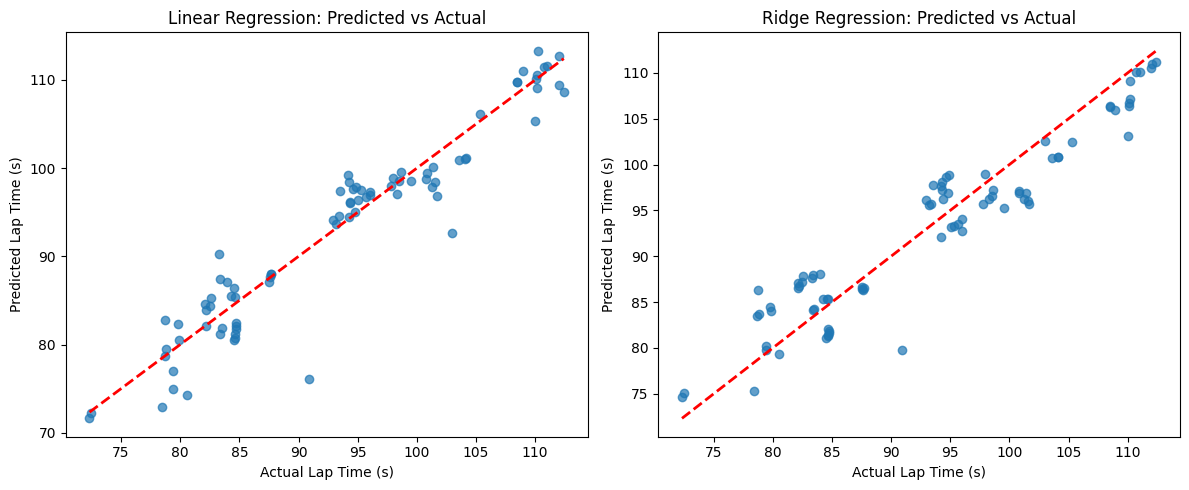


Overfitting Analysis:
Linear Regression gap: 0.104 seconds
Ridge Regression gap: -0.130 seconds


In [27]:
# TRAIN THE MODEL 
# I am using simpler regression models here because earlier tests with XGBoost and ANNs led to severe overfitting due to the lack of data (we only have 80 rows)
# Of course with time there is the option of...drumroll...getting MORE data. But due to time constraints this is what we have to work with.

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt

drivers = train_df['Driver'].copy()

# Encode categoricals
le_team = LabelEncoder()
le_race = LabelEncoder()
# le_driver = LabelEncoder()

train_df['TeamId_encoded'] = le_team.fit_transform(train_df['TeamId'])
train_df['Race_encoded'] = le_race.fit_transform(train_df['Race'])
# train_df['Driver_encoded'] = le_driver.fit_transform(train_df['Driver'])

X_init = train_df.drop(columns=['Driver', 'TeamId', 'Race', 'TotalSectorTime (s)'])
X_init = X_init.fillna(0)

# Fit min-max scaler on training data
norm = MinMaxScaler().fit(X_init)
 
# Transform the training data
X = norm.transform(X_init)
print("FINAL TRAINING DATA\n")
X

X = pd.DataFrame(X, columns=X_init.columns)

# Reset indices to ensure alignment
X_reset = X.reset_index(drop=True)
y_reset = y.reset_index(drop=True) 
drivers_reset = drivers.reset_index(drop=True)

# Now create the boolean mask
valid_indices = y_reset.notna().squeeze()

# Apply the mask
X_clean = X_reset[valid_indices]
y_clean = y_reset[valid_indices]  
drivers_clean = drivers_reset[valid_indices]

print(f"Original shape: X{X_reset.shape}, y{y_reset.shape}")
print(f"After cleaning: X{X_clean.shape}, y{y_clean.shape}")

# Now use the cleaned data for train_test_split
X_train, X_test, y_train, y_test, drivers_train, drivers_test = train_test_split(
    X_clean, y_clean, drivers_clean, test_size=0.25, random_state=42
)

# print(" Y TRAIN : ",y_train)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

ridge_model = Ridge(alpha=5.0) # Increased regularisation to prevent overfitting (from a lot of trial runs...)
ridge_model.fit(X_train, y_train)

lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

ridge_train_pred = ridge_model.predict(X_train)
ridge_test_pred = ridge_model.predict(X_test)

# Debug the array shapes
print("Debug info:")
print(f"drivers_test shape: {drivers_test.shape}")
print(f"drivers_test type: {type(drivers_test)}")
print(f"lr_test_pred shape: {lr_test_pred.shape}")
print(f"lr_test_pred type: {type(lr_test_pred)}")
print(f"y_test shape: {y_test.shape}")
print(f"y_test type: {type(y_test)}")

# Check if they're all the same length
print(f"drivers_test length: {len(drivers_test)}")
print(f"lr_test_pred length: {len(lr_test_pred)}")
print(f"y_test length: {len(y_test)}")

# Evaluate models
print("\n=== LINEAR REGRESSION ===")
print(f"Training MAE: {mean_absolute_error(y_train, lr_train_pred):.3f} seconds")
print(f"Test MAE: {mean_absolute_error(y_test, lr_test_pred):.3f} seconds")
print(f"Test R²: {r2_score(y_test, lr_test_pred):.3f}")

print("\n=== RIDGE REGRESSION ===")
print(f"Training MAE: {mean_absolute_error(y_train, ridge_train_pred):.3f} seconds")
print(f"Test MAE: {mean_absolute_error(y_test, ridge_test_pred):.3f} seconds")
print(f"Test R²: {r2_score(y_test, ridge_test_pred):.3f}")

print("X COLUMNS: ",X.columns)
print("COEFS : ",lr_model.coef_[0])
# Feature importance 
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features (Linear Regression):")
print(feature_importance.head(10))

# Convert everything to 1D numpy arrays
drivers_array = np.array(drivers_test).flatten()
pred_array = np.array(lr_test_pred).flatten()
actual_array = np.array(y_test).flatten()

test_results = pd.DataFrame({
    'Driver': drivers_array,
    'Predicted_LapTime': pred_array,
    'Actual_LapTime': actual_array
}).sort_values('Predicted_LapTime')

print("\nPredicted Fastest 3 Drivers (Test Set):")
print(test_results.head(3))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, lr_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Lap Time (s)')
plt.ylabel('Predicted Lap Time (s)')
plt.title('Linear Regression: Predicted vs Actual')

plt.subplot(1, 2, 2)
plt.scatter(y_test, ridge_test_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Lap Time (s)')
plt.ylabel('Predicted Lap Time (s)')
plt.title('Ridge Regression: Predicted vs Actual')

plt.tight_layout()
plt.show()

# Check overfitting
overfitting_gap_lr = mean_absolute_error(y_test, lr_test_pred) - mean_absolute_error(y_train, lr_train_pred)
overfitting_gap_ridge = mean_absolute_error(y_test, ridge_test_pred) - mean_absolute_error(y_train, ridge_train_pred)

print(f"\nOverfitting Analysis:")
print(f"Linear Regression gap: {overfitting_gap_lr:.3f} seconds")
print(f"Ridge Regression gap: {overfitting_gap_ridge:.3f} seconds")

In [28]:
# Check correlation between features and target
correlations = X_clean.corrwith(y_clean.squeeze()).abs().sort_values(ascending=False)
print("Feature correlations with target:")
print(correlations.head(10))

# Check for perfect correlations (1.0)
perfect_corr = correlations[correlations > 0.99]
print(f"\nFeatures with correlation > 0.99:")
print(perfect_corr)

Feature correlations with target:
CleanAirPace_seconds       0.854406
TrackTemp                  0.547806
Rain                       0.382358
Year                       0.377420
AirTemp                    0.309504
Race_encoded               0.193199
Is_Monza                   0.171480
Practice_Gap_to_Fastest    0.167221
Pressure                   0.061771
WindSpeed                  0.058134
dtype: float64

Features with correlation > 0.99:
Series([], dtype: float64)


As estimated, Track Temperature, Sector Time and Clean Air Race Pace are the most important features.

In [29]:
X

,GridPosition,Grid_Gap_to_Pole,Quali_vs_Teammate,Year,CleanAirPace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,AirTemp,Pressure,Rain,WindSpeed,TrackTemp,Is_Monza,TeamId_encoded,Race_encoded
0,0.052632,0.052632,0.138889,0.0,0.926216,0.069301,0.538462,0.771206,0.982959,0.0,0.229152,0.838213,0.0,0.444444,0.1875
1,0.000000,0.000000,0.444444,0.0,0.943933,0.286051,0.807692,0.771206,0.982959,0.0,0.229152,0.838213,0.0,0.222222,0.1875
2,0.210526,0.210526,0.111111,0.0,0.920552,0.000000,0.346154,0.771206,0.982959,0.0,0.229152,0.838213,0.0,0.555556,0.1875
3,0.736842,0.736842,0.861111,0.0,0.925927,0.065762,0.000000,0.771206,0.982959,0.0,0.229152,0.838213,0.0,0.444444,0.1875
4,0.263158,0.263158,0.555556,0.0,0.928940,0.102625,0.423077,0.771206,0.982959,0.0,0.229152,0.838213,0.0,0.777778,0.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,1.000000,1.000000,0.583333,1.0,0.383816,0.270127,0.442308,0.774673,0.706611,0.0,0.393060,0.803205,1.0,0.000000,0.7500
335,0.842105,0.842105,0.416667,1.0,0.378682,0.207313,0.384615,0.774673,0.706611,0.0,0.393060,0.803205,1.0,0.000000,0.7500
336,0.789474,0.789474,0.722222,1.0,0.383816,0.270127,0.596154,0.774673,0.706611,0.0,0.393060,0.803205,1.0,0.111111,0.7500
337,0.368421,0.368421,0.277778,1.0,0.374512,0.156296,0.653846,0.774673,0.706611,0.0,0.393060,0.803205,1.0,0.111111,0.7500


In [ ]:
#----------------CREATE PREDICTION DATASET-----------------

predict_df=pd.DataFrame()
predict_df['Abbreviation']=['PIA','NOR','HAM','LEC','RUS','ANT','LAW','HAD','SAI','ALB','VER','TSU','ALO','STR','BEA','OCO','BOR','HUL','GAS','COL']

# Create driver to team mapping (2025 season)
driver_to_team = {
    'PIA': 'mclaren',
    'NOR': 'mclaren', 
    'HAM': 'ferrari',       
    'LEC': 'ferrari',
    'RUS': 'mercedes',
    'ANT': 'mercedes',      
    'LAW': 'rb',           
    'HAD': 'rb',
    'SAI': 'williams',       
    'ALB': 'williams',
    'VER': 'red_bull',
    'TSU': 'red_bull',           
    'ALO': 'aston_martin',
    'STR': 'aston_martin',
    'BEA': 'haas',          
    'OCO': 'haas',
    'BOR': 'sauber',       
    'HUL': 'sauber',
    'GAS': 'alpine',
    'COL': 'alpine'    
}

predict_df['TeamId'] = predict_df['Abbreviation'].map(driver_to_team)
# predict_df['TeamId_encoded'] = le_team.transform(predict_df['TeamId'])

grid_positions = {
    'VER': 1.0,
    'NOR': 2.0, 
    'PIA': 3.0,
    'LEC': 4.0,
    'RUS': 5.0,
    'ANT': 6.0,       
    'BOR': 7.0,          
    'ALO': 8.0,
    'TSU': 9.0,    
    'HAM': 10.0,
    'BEA': 11.0,            
    'HUL': 12.0,
    'SAI': 13.0,
    'ALB': 14.0,          
    'OCO': 15.0,
    'HAD': 16.0,       
    'STR': 17.0,
    'COL': 18.0,
    'GAS': 19.0,  
    'LAW': 20.0
}


predict_df['GridPosition'] = predict_df['Abbreviation'].map(grid_positions)
predict_df['Grid_Gap_to_Pole'] = predict_df['GridPosition'] - predict_df['GridPosition'].min()
predict_df['Quali_vs_Teammate'] = predict_df.groupby('TeamId')['GridPosition'].transform(lambda x: x - x.mean())

predict_df['Race'] = 'Monza'
predict_df['Race_encoded'] = le_race.transform(predict_df['Race']) #2
predict_df['TeamId_encoded']=le_team.transform(predict_df['TeamId'])
predict_df['Year'] = 2025

predict_df['Is_Monza']=1

clean_air_race_pace=get_clean_air_race_pace(2025,'Monza')
clean_air_race_pace.drop(columns=['IsPersonalBest','Session'],inplace=True)
pace_mapping=clean_air_race_pace.set_index('Driver')['LapTime (s)']
predict_df['CleanAirPace_seconds'] = predict_df['Abbreviation'].map(pace_mapping)
        
predict_df['Practice_Gap_to_Fastest'] = predict_df['CleanAirPace_seconds'] - predict_df['CleanAirPace_seconds'].min()
predict_df['Practice_vs_Quali_Rank'] = predict_df['CleanAirPace_seconds'].rank() - predict_df['GridPosition']
predict_df['Quali_vs_Teammate'] = predict_df['Quali_vs_Teammate'].fillna(0)

        
#Predicted Air Temp: 21 Celsius, Pressure= 1008 mbar, windspeed 4 m/s and no Rainfall
predict_df['Rain']=False
predict_df['AirTemp'] = 27.000000
predict_df['TrackTemp']=44.000000
predict_df['Pressure']=1017.100000
predict_df['WindSpeed']=2.777800


predict_df.drop(columns=['TeamId'],inplace=True)
predict_df.drop(columns=['Race'],inplace=True)

predict_df

core           INFO 	Loading data for Italian Grand Prix - Practice 1 [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
core        WARNING 	No lap data for driver 3
core        WARNING 	No lap data for driver 7
core        WARNING 	No lap data for driver 9
core        WARNING 	No lap data for driver 11
core        WARNING 	No lap data for driver 15
core        WARNING 	No lap data for driver 17
core        WARNING 	No lap data for driver 19
core        WARNING 	No lap data for driver 21
core        WARNING 	No lap data for driver 25
core        WARNING 	No lap data for driver 29
core        WARNING 	Failed to perform lap accur

,Abbreviation,GridPosition,Grid_Gap_to_Pole,Quali_vs_Teammate,Race_encoded,TeamId_encoded,Year,Is_Monza,CleanAirPace_seconds,Practice_Gap_to_Fastest,Practice_vs_Quali_Rank,Rain,AirTemp,TrackTemp,Pressure,WindSpeed
0,PIA,3.0,2.0,0.5,11,4,2025,1,79.496,0.165,0.0,False,27.0,44.0,1017.1,2.7778
1,NOR,2.0,1.0,-0.5,11,4,2025,1,79.331,0.000,-1.0,False,27.0,44.0,1017.1,2.7778
2,HAM,10.0,9.0,3.0,11,2,2025,1,79.598,0.267,-3.0,False,27.0,44.0,1017.1,2.7778
3,LEC,4.0,3.0,-3.0,11,2,2025,1,79.352,0.021,-2.0,False,27.0,44.0,1017.1,2.7778
4,RUS,5.0,4.0,-0.5,11,5,2025,1,79.515,0.184,0.0,False,27.0,44.0,1017.1,2.7778
5,ANT,6.0,5.0,0.5,11,5,2025,1,79.696,0.365,3.0,False,27.0,44.0,1017.1,2.7778
6,LAW,20.0,19.0,2.0,11,6,2025,1,80.132,0.801,-4.0,False,27.0,44.0,1017.1,2.7778
7,HAD,16.0,15.0,-2.0,11,6,2025,1,79.603,0.272,-8.0,False,27.0,44.0,1017.1,2.7778
8,SAI,13.0,12.0,-0.5,11,9,2025,1,79.907,0.576,0.0,False,27.0,44.0,1017.1,2.7778
9,ALB,14.0,13.0,0.5,11,9,2025,1,79.720,0.389,-4.0,False,27.0,44.0,1017.1,2.7778


In [ ]:
predict_df.columns

Index(['Abbreviation', 'GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate',
       'Race_encoded', 'TeamId_encoded', 'Year', 'Is_Monza',
       'CleanAirPace_seconds', 'Practice_Gap_to_Fastest',
       'Practice_vs_Quali_Rank', 'Rain', 'AirTemp', 'TrackTemp', 'Pressure',
       'WindSpeed'],
      dtype='object')

In [ ]:
# Reorder prediction features to match training order
feature_order = ['GridPosition', 'Grid_Gap_to_Pole', 'Quali_vs_Teammate', 'Year', 
                'CleanAirPace_seconds', 'Practice_Gap_to_Fastest', 'Practice_vs_Quali_Rank', 
                'AirTemp', 'Pressure', 'Rain', 'WindSpeed','TrackTemp','Is_Monza', 'TeamId_encoded', 'Race_encoded']

#CHECK HERE IN DUTCH GP NOTEBOOK FOR DIFFERENCES IN FEATURE ENGINEERING
# REMOVE DRIVER_ENCODED

X_predict = predict_df[feature_order]

# Handle missing values
X_predict = X_predict.fillna(0)

# print("Feature alignment check:")
# print("Training:", list(X.columns))
# print("Prediction:", list(X_predict.columns))
# print("Match:", list(X.columns) == list(X_predict.columns))

#Make Predictions
predicted_lap_times = ridge_model.predict(X_predict)

print("PREDICTIONS")
print(predicted_lap_times)

results_df = pd.DataFrame({
    'Driver': predict_df['Abbreviation'],
    'Predicted_LapTime': predicted_lap_times
}).sort_values('Predicted_LapTime')

# Get top 3 fastest 
print("\nPREDICTED 2025 MONZA PODIUM")
print("===============================")
print(f"🥇 P1: {results_df.iloc[0]['Driver']} - {results_df.iloc[0]['Predicted_LapTime']}s")
print(f"🥈 P2: {results_df.iloc[1]['Driver']} - {results_df.iloc[1]['Predicted_LapTime']}s") 
print(f"🥉 P3: {results_df.iloc[2]['Driver']} - {results_df.iloc[2]['Predicted_LapTime']}s")

print("\nFull Results:")
results_df.reset_index(drop=True, inplace=True)
print(results_df.head(10))

PREDICTIONS
[90.13273765 90.08894639 91.19013253 90.50787309 90.89055768 91.41284137
 93.06352051 92.48959845 92.69972614 92.49699773 90.68198588 92.02468261
 91.97208106 92.68012533 92.43103984 93.00804586 91.48797588 92.35533285
 93.05255859 92.49588231]

PREDICTED 2025 MONZA PODIUM
🥇 P1: NOR - 90.08894638938864s
🥈 P2: PIA - 90.13273764799897s
🥉 P3: LEC - 90.50787309193493s

Full Results:
  Driver  Predicted_LapTime
0    NOR          90.088946
1    PIA          90.132738
2    LEC          90.507873
3    VER          90.681986
4    RUS          90.890558
5    HAM          91.190133
6    ANT          91.412841
7    BOR          91.487976
8    ALO          91.972081
9    TSU          92.024683


In [ ]:
ridge_prediction=ridge_model.predict(X_predict)
ridge_prediction

array([90.13273765, 90.08894639, 91.19013253, 90.50787309, 90.89055768,
       91.41284137, 93.06352051, 92.48959845, 92.69972614, 92.49699773,
       90.68198588, 92.02468261, 91.97208106, 92.68012533, 92.43103984,
       93.00804586, 91.48797588, 92.35533285, 93.05255859, 92.49588231])

In [ ]:
ridge_model.score(X_test,y_test)

0.845028056729119

In [ ]:
coefs = pd.DataFrame(
    abs(ridge_model.coef_), columns=["Coefficients"], index=X_train.columns
)
coefs.columns

Index(['Coefficients'], dtype='object')

In [ ]:
coefs.sort_values(by='Coefficients',ascending=False)

,Coefficients
Rain,6.563962
WindSpeed,3.881627
Practice_Gap_to_Fastest,3.849123
Is_Monza,1.281433
Year,1.281433
CleanAirPace_seconds,0.805176
Race_encoded,0.450193
TrackTemp,0.391730
AirTemp,0.389208
Practice_vs_Quali_Rank,0.263598


In [ ]:
# FUTURE WORK
# Normalisation of features
# Add in skill based ranking?
# Constructor Standing/points?
# Add in Qualifying time? Will risk perfect correlation with GridPosition
# Change target variable?


In [ ]:
monza_res=fastf1.get_session(2025,'Monza','R')
monza_res.load()
monza_res.results

core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '63', '44', '23', '5', '12', '6', '55', '87', '22', '30', '31', '10', '43', '18', '14', '27']


,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,Position,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points,Laps
1,1,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,4781D7,red_bull,Max,Verstappen,Max Verstappen,...,1.0,1,1.0,NaT,NaT,NaT,0 days 01:13:24.325000,Finished,25.0,53.0
4,4,L NORRIS,NOR,norris,McLaren,F47600,mclaren,Lando,Norris,Lando Norris,...,2.0,2,2.0,NaT,NaT,NaT,0 days 00:00:19.207000,Finished,18.0,53.0
81,81,O PIASTRI,PIA,piastri,McLaren,F47600,mclaren,Oscar,Piastri,Oscar Piastri,...,3.0,3,3.0,NaT,NaT,NaT,0 days 00:00:21.351000,Finished,15.0,53.0
16,16,C LECLERC,LEC,leclerc,Ferrari,ED1131,ferrari,Charles,Leclerc,Charles Leclerc,...,4.0,4,4.0,NaT,NaT,NaT,0 days 00:00:25.624000,Finished,12.0,53.0
63,63,G RUSSELL,RUS,russell,Mercedes,00D7B6,mercedes,George,Russell,George Russell,...,5.0,5,5.0,NaT,NaT,NaT,0 days 00:00:32.881000,Finished,10.0,53.0
44,44,L HAMILTON,HAM,hamilton,Ferrari,ED1131,ferrari,Lewis,Hamilton,Lewis Hamilton,...,6.0,6,10.0,NaT,NaT,NaT,0 days 00:00:37.449000,Finished,8.0,53.0
23,23,A ALBON,ALB,albon,Williams,1868DB,williams,Alexander,Albon,Alexander Albon,...,7.0,7,14.0,NaT,NaT,NaT,0 days 00:00:50.537000,Finished,6.0,53.0
5,5,G BORTOLETO,BOR,bortoleto,Kick Sauber,01C00E,sauber,Gabriel,Bortoleto,Gabriel Bortoleto,...,8.0,8,7.0,NaT,NaT,NaT,0 days 00:00:58.484000,Finished,4.0,53.0
12,12,K ANTONELLI,ANT,antonelli,Mercedes,00D7B6,mercedes,Kimi,Antonelli,Kimi Antonelli,...,9.0,9,6.0,NaT,NaT,NaT,0 days 00:00:59.762000,Finished,2.0,53.0
6,6,I HADJAR,HAD,hadjar,Racing Bulls,6C98FF,rb,Isack,Hadjar,Isack Hadjar,...,10.0,10,19.0,NaT,NaT,NaT,0 days 00:01:03.891000,Finished,1.0,53.0
